# Flight Disruption Risk - Insight Week 3
----------------------------------------------


The goal of this project is two-fold:
1. Find to probability for disruption of *n*-flights at each airport
2. Clustering airport that exhibit a similar behavior

In [2]:
import pandas as pd
import numpy as np
import AffinityClustering as AC
import math

import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap


LIB='./data/'



## The Data
------
On-time performance of domestic flights depart from US airport. 

Data was downloaded from BTS.gov 

(Only * **partial** * flight data available. The analysis was down for two years data from Dec. 2015 to Nov. 2017). 


Example of the data:

In [3]:
df=pd.read_csv(LIB + '/BackupData/022017.csv')
df.head(5)

,FL_DATE,CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_TIME,CANCELLED,CANCELLATION_CODE,Unnamed: 11
0,2017-02-01,HA,KOA,HNL,952,950.0,0.0,1038,1031.0,0.0,NaN,NaN
1,2017-02-01,HA,HNL,KOA,837,831.0,0.0,922,921.0,0.0,NaN,NaN
2,2017-02-01,HA,ITO,HNL,850,843.0,0.0,942,932.0,0.0,NaN,NaN
3,2017-02-01,HA,HNL,ITO,729,719.0,0.0,821,814.0,0.0,NaN,NaN
4,2017-02-01,HA,HNL,LIH,725,719.0,0.0,804,806.0,0.0,NaN,NaN


The data is grouped by airport, and the total flight disruption per day is calculated.

In [4]:
df[['FL_DATE','ORIGIN','CANCELLED']].groupby(['FL_DATE','ORIGIN']).mean()

CANCELLED
FL_DATE    ORIGIN           
2017-02-01 ABE      0.000000
           ABI      0.000000
           ABQ      0.044444
           ABR      0.000000
           ABY      0.000000
           ACT      0.000000
           ACV      0.000000
           ACY      0.000000
           ADQ      0.000000
           AEX      0.000000
           AGS      0.000000
           ALB      0.000000
           AMA      0.000000
           ANC      0.000000
           APN      0.000000
           ASE      0.000000
           ATL      0.000000
           ATW      0.000000
           AUS      0.000000
           AVL      0.000000
           AVP      0.000000
           AZO      0.000000
           BDL      0.000000
           BET      0.000000
           BFL      0.000000
           BGM      0.000000
           BHM      0.000000
           BIL      0.000000
           BIS      0.000000
           BJI      0.000000
...                      ...
2017-02-28 SJU      0.000000
           SLC      0.000000
           SMF      0.008547
           SNA      0.000000
           SPI      0.200000
           SPS      0.000000
           SRQ      0.000000
           STL      0.012500
           STS      0.000000
           STT      0.071429
           STX      0.000000
           SUN      0.800000
           SWF      0.000000
           SYR      0.000000
           TLH      0.000000
           TPA      0.000000
           TRI      0.000000
           TTN      0.000000
           TUL      0.000000
           TUS      0.000000
           TVC      0.000000
           TWF      0.000000
           TYR      0.000000
           TYS      0.052632
           VLD      0.000000
           VPS      0.000000
           WRG      0.000000
           XNA      0.066667
           YAK      0.000000
           YUM      0.000000

[8110 rows x 1 columns]

we can also plot the cancellation ratio as a time series for each airport:

The file "cancelled.csv" contains a time series for each airport that indicate the fraction of the flights that were disrupted

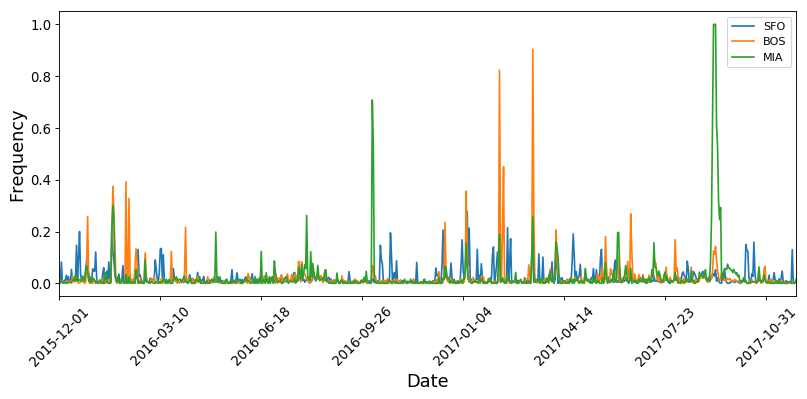

In [16]:
cancelled=pd.read_csv(LIB+'cancelled.csv', index_col='FL_DATE')
cancelled.fillna(value=0,inplace=True)

fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
f2=cancelled.plot(style='-',y=['SFO','BOS','MIA'], ax=ax,x_compat=True, fontsize=12, rot=45)# s=1, c=1, alpha=1,cmap='jet')
cancelled=cancelled.transpose()
plt.tight_layout()
plt.xlabel("Date",Fontsize=16)
plt.ylabel("Frequency", Fontsize=16)

plt.show()

## The probability for extreme event
----------------------------------------
Goal: Find the distribution of disrupted flights for each airport.

The number of disrupted flights per day, assumed each event is indpenedent from each other, follows the Poisson distribution: the parameter $\lambda$ provides information on the expected number of disrupted flight and the likelihood of an extreme event.

Method: Using PyMC - a Python package for Bayesian statistical modeling and probabilistic machine learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms.



In [50]:
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm

LIB='./data/'

df=pd.read_csv(LIB + 'cancelled.csv', index_col='FL_DATE')
df.fillna(value=0,inplace=True)
#counts.csv the total flights per day at each airport
dt=pd.read_csv(LIB + 'counts.csv',index_col='FL_DATE')
dt.fillna(value=0,inplace=True)

#number of flight that were canc
dx=pd.DataFrame(df.values*dt.values, columns=df.columns, index=df.index, dtype=int)


Histogram of the number of disrupted flights.

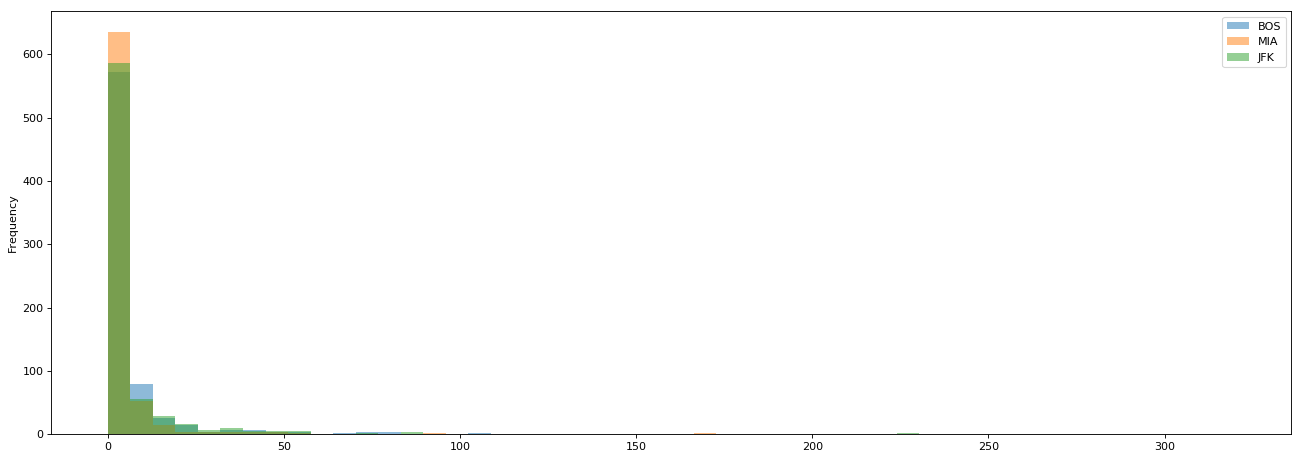

In [51]:
fig, ax = plt.subplots(num=None, figsize=(20, 7), dpi=80, facecolor='w', edgecolor='k')

dx[['BOS','MIA','JFK']].plot(kind='hist', bins=50, ax=ax, alpha=.5)
plt.show()

###  The parameter $\lambda$ of the Poisson distribution

The parameter of the Poisson distribution (Which equals to the mean and to the standard deviation) measures the average number of events and provides the probability of the number of disrupted flights per day.

I model $\lambda$ using an exponential distribution as a prior probability distribution, and use probablistic programing (PyMC) to find its value.

In [52]:
airportID='BOS'
dg=dx[airportID]

alpha=1.0/dg.mean()   #alpha is an hyperparameter that gives an intial guess for lambda=1/alpha
lambda1=pm.Exponential("lambda1", alpha) #prior deistribution
#Likelihood
observation=pm.Poisson("obs", lambda1, value=dg, observed=True)
model=pm.Model([observation,lambda1])
mcmc=pm.MCMC(model)
mcmc.sample(40000,10000)

lambda1samples=mcmc.trace('lambda1')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 3.6 sec

ploting the results

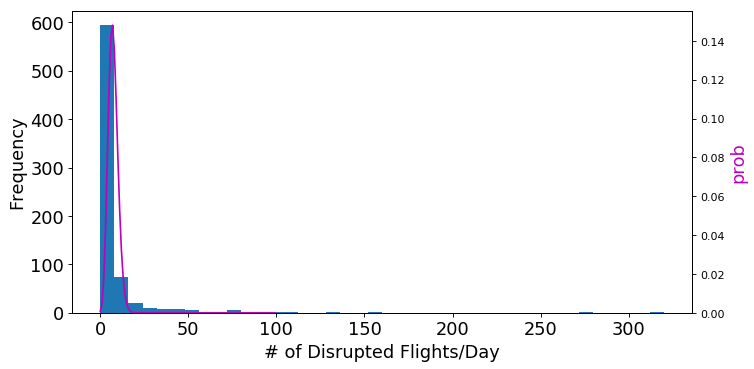

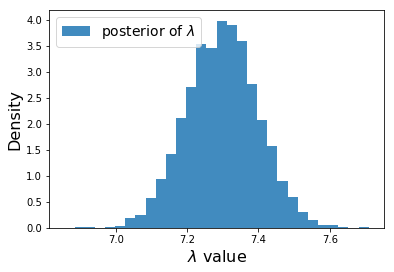

In [89]:
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

ax=dg.plot(kind='hist', bins=40, ax=ax)
plt.ylabel("Frequency", Fontsize=16)
plt.xlabel("# of Disrupted Flights/Day",Fontsize=16)
plt.tick_params(labelsize=16)

xp=list(range(100))
l=lambda1samples.mean()
pois=[(l**k)*np.exp(-l)/math.factorial(k) for k in xp]
ax2 = ax.twinx()
ax2.plot(xp,pois,color='m')
ax2.set_ylabel('prob', color='m', Fontsize=16)
ax2.set_ylim([0,ax2.get_ylim()[1]])

plt.show()

# The distribution of lambda
plt.hist(lambda1samples,histtype='stepfilled',bins=30,alpha=.85, label="posterior of $\lambda$",normed=True)
plt.legend(loc="upper left", prop={'size': 14})
plt.xlabel("$\lambda$ value", Fontsize=16)
plt.ylabel("Density", Fontsize=16)
plt.tick_params(labelsize=10)
plt.savefig('lambda.png')
plt.show()


## Clustering airports
-------------------------------
Next, The Gaussian mixture model was used to cluster airports that exhibit similar pattern of flight disruption.

The Gaussian mixture model is a generative model that is used to find a probabilistic cluster assignment for each airport. We apply this tool on the distance matrix that shows how different the pattern of each airport from each other.

The Bayesian Information Creterion (BIC) was used to cross-validate the number of components and $k=7$ was chosen as the optimal number of clusters.

In [94]:
# Calculate the distance matrix and find the K - Eigen vectors (amount of clusters)

k=7


vals,vecs=AC.AffinityMatrix(cancelled.values, k)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=k).fit(vecs)
labels = gmm.predict(vecs)
    
probs = gmm.predict_proba(vecs)

In [95]:
airportID='BOS'
indA=cancelled.index.get_loc(airportID)
clus=pd.DataFrame(np.max(probs[labels==labels[indA]],axis=1),index=cancelled.index[labels==labels[indA]])

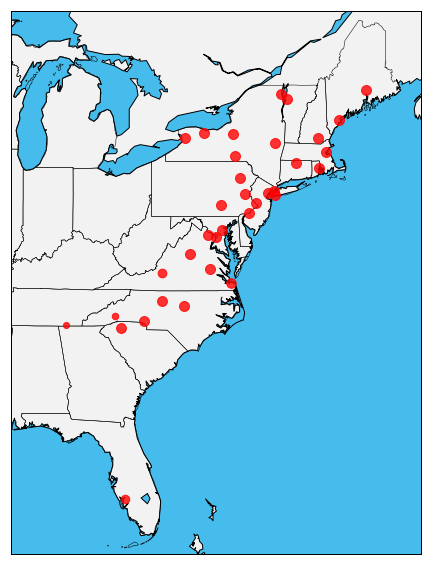

In [96]:
import USmap as USM
def plot_area(pos):
    x, y = m(pos[1], pos[0])
    size = ((pos[2])**3)*10
    m.plot(x, y, 'o', markersize=size, color='red', alpha=0.8)
    
airports=pd.read_csv('./data/allairports.csv',index_col=0)


ind=clus.index

airports=pd.concat([airports.loc[ind,:], clus], axis=1)
WL=airports.longitude_deg.min()-3
EL=airports.longitude_deg.max()+3
SL=airports.latitude_deg.min()-3
NL=airports.latitude_deg.max()+3


m=USM.plot_map(WL,SL,EL,NL)
for i,row in airports.iterrows():
    plot_area(row.loc[['latitude_deg','longitude_deg','prob']].values)



plt.show()


Finally, we can predict the highly correlated airports in the cluster to the chosen airport (airportID):

The number are indication of similarity (non-normalized) 

In [58]:
ind=clus.index
D = pd.DataFrame(AC.DistanceMatrix(cancelled.loc[ind,:].values), index=ind, columns=ind)
top=D[airportID].sort_values().to_frame() 
top.head(6)

,BOS
BOS,0.000000
BDL,1.002772
PVD,1.048090
PHL,1.429861
BUF,1.455965
JFK,1.525162


## Next Step
-----------

Find the conditional probabilities.

**Hypothesis**: The conditional probability between two highly correlated airport X and Y that obey Poisson distribution *may* be Binomial distribution where $P(Y | X=k) = Binomial(k,\lambda_y/\lambda_x)$, where $\lambda$ are normalized to the total flight numbers per day at airport X and Y, respectively.

